In [1]:
import os
os.chdir("..")
os.getcwd()

'/home/bbd0953/diffusion'

In [2]:
from pathlib import Path

import numpy as np
import torch
from torchvision.transforms import ToTensor, Compose, CenterCrop
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils import plot_samples
from lofar_data import LofarUnlabeled


Methods:
- Consider FID
- Find closest matching pairs
- normalized histograms of:
    - pixel intensities
    - number of pixels with an intensity greater than zero
    - the sum of intensities
- RMAE for distributions (difference / sum for each bin)

Attention!
- Images should be scaled between 0 and 1 

# Datasets

## Utils

In [3]:
class ImagePathDataset(torch.utils.data.Dataset):
    # From:
    #  https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py
    def __init__(self, path, transforms=None):
        self.path = path
        self.files = sorted(self.path.iterdir())
        self.transforms = transforms

        print("Loading images...")
        load = lambda f: Image.open(f)
        self.data = list(map(load, tqdm(self.files)))

        print("Data set initialized.")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        img = self.data[i]
        if self.transforms is not None:
            img = self.transforms(img)
        return img


## Load:

### LOFAR Whole Set

In [10]:
transform = Compose([
        ToTensor(),
        CenterCrop(80),
    ])

ds_lofar = LofarUnlabeled("./data", las_thr=[40, 120], flux_thr=5,
                            transform=transform)

Loading images...


100%|██████████| 84411/84411 [02:05<00:00, 671.00it/s]  

Data set initialized.


### Lofar Subset:

In [1]:
subset_folder = Path("./data/lofar_subset")

transform = Compose([
        ToTensor(),
        CenterCrop(80),
        lambda img: img[:1,:,:],  # First channel only
    ])

ds_subset = ImagePathDataset(subset_folder, transform)

NameError: name 'Path' is not defined

### LOFAR random 10k picks:

In [26]:
# Generate by copying files
import random
import shutil

subset_folder = Path("./data/lofar_subset")

n_folders = 2
n_files = 10000
files = sorted(subset_folder.iterdir())

sample = random.sample(files, n_folders * n_files)

for i in range(n_folders):
    out_folder = Path(f"./data/lofar_rand10k_{i}")
    Path.mkdir(out_folder)
    files = sample[i*n_files : (i + 1)*n_files]
    for f in tqdm(files):
        shutil.copy(f, out_folder.joinpath(f.name))
    


100%|██████████| 10000/10000 [00:02<00:00, 3826.99it/s]


### Generated

#### Diffusion v1.0

In [32]:
gen_folder = Path("./data/generated/diffusion_v1.0")

transform = Compose([
        ToTensor(),
        CenterCrop(80),
        lambda img: img[:1,:,:],  # First channel only
    ])

ds_gen = ImagePathDataset(gen_folder, transform)

Loading images...


100%|██████████| 13500/13500 [00:02<00:00, 5219.60it/s]

Data set initialized.


#### Diffusion v1.0 with DDIM sampling

In [33]:
from astropy.stats import sigma_clipped_stats
from utils import clip_and_rescale

gen_folder = Path("./data/generated/diffusion_v1.0_DDIM")

transform = Compose([
        ToTensor(),
        CenterCrop(80),
        lambda img: img[:1,:,:],  # First channel only
    ])

ds_DDIM = ImagePathDataset(gen_folder, transform)

Loading images...


100%|██████████| 13500/13500 [00:02<00:00, 5201.88it/s]

Data set initialized.


# Analysis & Evaluation

## FID

Save FID stats of original

In [10]:
from pytorch_fid.fid_score import save_fid_stats

lofar_img_path = Path("./data/lofar_subset")
# For some reason, relative paths don't work here.
out_file = Path("/home/bbd0953/diffusion/data/lofar_subset_fid_stats")

save_fid_stats([str(lofar_img_path), str(out_file)],
                device=torch.device("cuda:1"),
                batch_size=64, dims=2048)


Saving statistics for data/lofar_subset


100%|██████████| 1319/1319 [00:53<00:00, 24.75it/s]


Validation with original 10k random picks:

In [27]:
rand0 = Path("./data/lofar_rand10k_1/")
rand1 = Path("./data/lofar_rand10k_0/")

fid_self = calculate_fid_given_paths([str(rand0), str(rand1)],
                          device=torch.device("cuda:1"),
                          batch_size=64, dims=2048)
print(fid_self)


100%|██████████| 157/157 [00:06<00:00, 24.81it/s]


0.5681567514369874


DDPM

In [18]:
from pytorch_fid.fid_score import calculate_fid_given_paths

lofar_fid_file = Path("/home/bbd0953/diffusion/data/lofar_subset_fid_stats.npz")
gen_img_path = Path("./data/generated/diffusion_v1.0")

fid_gen = calculate_fid_given_paths([str(lofar_fid_file), str(gen_img_path)],
                          device=torch.device("cuda:1"),
                          batch_size=64, dims=2048)

100%|██████████| 211/211 [00:07<00:00, 30.09it/s]


DDIM

In [16]:
from pytorch_fid.fid_score import calculate_fid_given_paths

lofar_fid_file = Path("/home/bbd0953/diffusion/data/lofar_subset_fid_stats.npz")
DDIM_img_path = Path("./data/generated/diffusion_v1.0_DDIM")

fid_DDIM = calculate_fid_given_paths([str(lofar_fid_file), str(DDIM_img_path)],
                          device=torch.device("cuda:1"),
                          batch_size=64, dims=2048)

100%|██████████| 211/211 [00:06<00:00, 31.14it/s]


In [19]:
print(fid_DDIM, fid_gen)

43.70423637741874 27.005545630475467


## Distributions

### Utils

In [58]:
def get_distributions(dataloader, 
                      intensity_bins=256, pixsum_bins=None, act_bins=None):
    std_sum_bins = torch.tensor(
        np.linspace(0, 6400, num=6400//50, endpoint=True)
    ).to(torch.float32)
    if pixsum_bins is None:
        pixsum_bins = std_sum_bins
    if act_bins is None:
        act_bins = std_sum_bins
        
    get_nbins = lambda bins: bins if isinstance(bins, int) else len(bins) - 1
    intensity_hist = torch.zeros(get_nbins(intensity_bins)).to('cuda:0')
    pixsum_hist = torch.zeros(get_nbins(pixsum_bins)).to('cuda:0')
    act_hist = torch.zeros(get_nbins(act_bins)).to('cuda:0')

    for img in tqdm(dataloader, desc="Calculating distributions..."):
        img.to('cuda:0')
        # Pixel intensities
        i_count, i_edges = torch.histogram(img, bins=intensity_bins)
        intensity_hist = torch.add(intensity_hist, i_count.to('cuda:0'))
        # Pixel sums
        p_count, p_edges = torch.histogram(torch.sum(img, (-1, -2)),
                                            bins=pixsum_bins)
        pixsum_hist = torch.add(pixsum_hist, p_count.to('cuda:0'))
        # Activated pixels
        n_act = torch.sum((img>=1./256).squeeze(), [-2, -1]).to(torch.float32)  # Shape: [b]
        act_count, act_edges = torch.histogram(n_act, 
                                                   bins=act_bins)
        act_hist = torch.add(act_hist, act_count.to('cuda:0'))
        
    out = {
        "Pixel Intensity": (intensity_hist.to('cpu'), i_edges.to('cpu')),
        "Pixel Sum": (pixsum_hist.to('cpu'), p_edges.to('cpu')),
        "Activated Pixels": (act_hist.to('cpu'), act_edges.to('cpu'))
    }
    return out

def per_bin_error(distr1, distr2):
    error_dict = {}

    for key in distr1.keys():
        # Counts & Edges
        C1, edges = distr1[key]
        C2, _ = distr2[key]

        C1_bar = torch.sum(C1)
        C2_bar = torch.sum(C2)

        c1 = C1 / C1_bar
        c2 = C2 / C2_bar

        e1_sq = C1 / C1_bar**3 * (C1_bar - C1)
        e2_sq = C2 / C2_bar**3 * (C2_bar - C2)


        error = 2 * (c1 - c2) / (c1 + c2)
        error_delta_squared = 16 * (
            (e1_sq * c2**2 + e2_sq * c1**2) / (c1 + c2)**4
        )

        # Replace NaN entries (from division by 0 for entries where c1 = c2 = 0)
        # with 0:
        error[error != error] = 0
        error_delta_squared[error_delta_squared != error_delta_squared] = 0

        error_dict[key] = (error, error_delta_squared, edges)
    
    return error_dict

def RMAE(error_dict):
    rmae_dict = {}
    for key in error_dict:
        per_bin_error = error_dict[key][0]
        per_bin_error_delta_sq = error_dict[key][1]
        norm = len(per_bin_error)
        rmae = torch.sum(torch.abs(per_bin_error)) / norm
        rmae_delta_squared = torch.sum(per_bin_error_delta_sq) / norm**2
        
        rmae_dict[key] = (rmae, rmae_delta_squared)
    
    norm = len(rmae_dict)
    score = torch.sum(torch.stack([v[0] for v in rmae_dict.values()])) / norm
    score_delta_squared = torch.sum(torch.stack([v[1] for v in rmae_dict.values()])) / norm
    rmae_dict["Sum"] = (score, score_delta_squared)

    return rmae_dict


### Compare LOFAR and Generated

Generate distributions:

In [38]:
bsize = 500
get_dl = lambda ds: DataLoader(ds, batch_size=bsize)

dl_lofar = get_dl(ds_subset)
dl_gen = get_dl(ds_gen)

distr_lofar = get_distributions(dl_lofar,)
                                # pixsum_bins=pixsum_bins,
                                # act_bins=act_bins)

Calculating distributions...: 100%|██████████| 169/169 [00:33<00:00,  5.07it/s]


In [39]:
distr_gen = get_distributions(dl_gen,)

Calculating distributions...: 100%|██████████| 27/27 [00:05<00:00,  5.05it/s]


In [60]:
error = per_bin_error(distr_lofar, distr_gen)
rmae = RMAE(error)

Plot distributions:

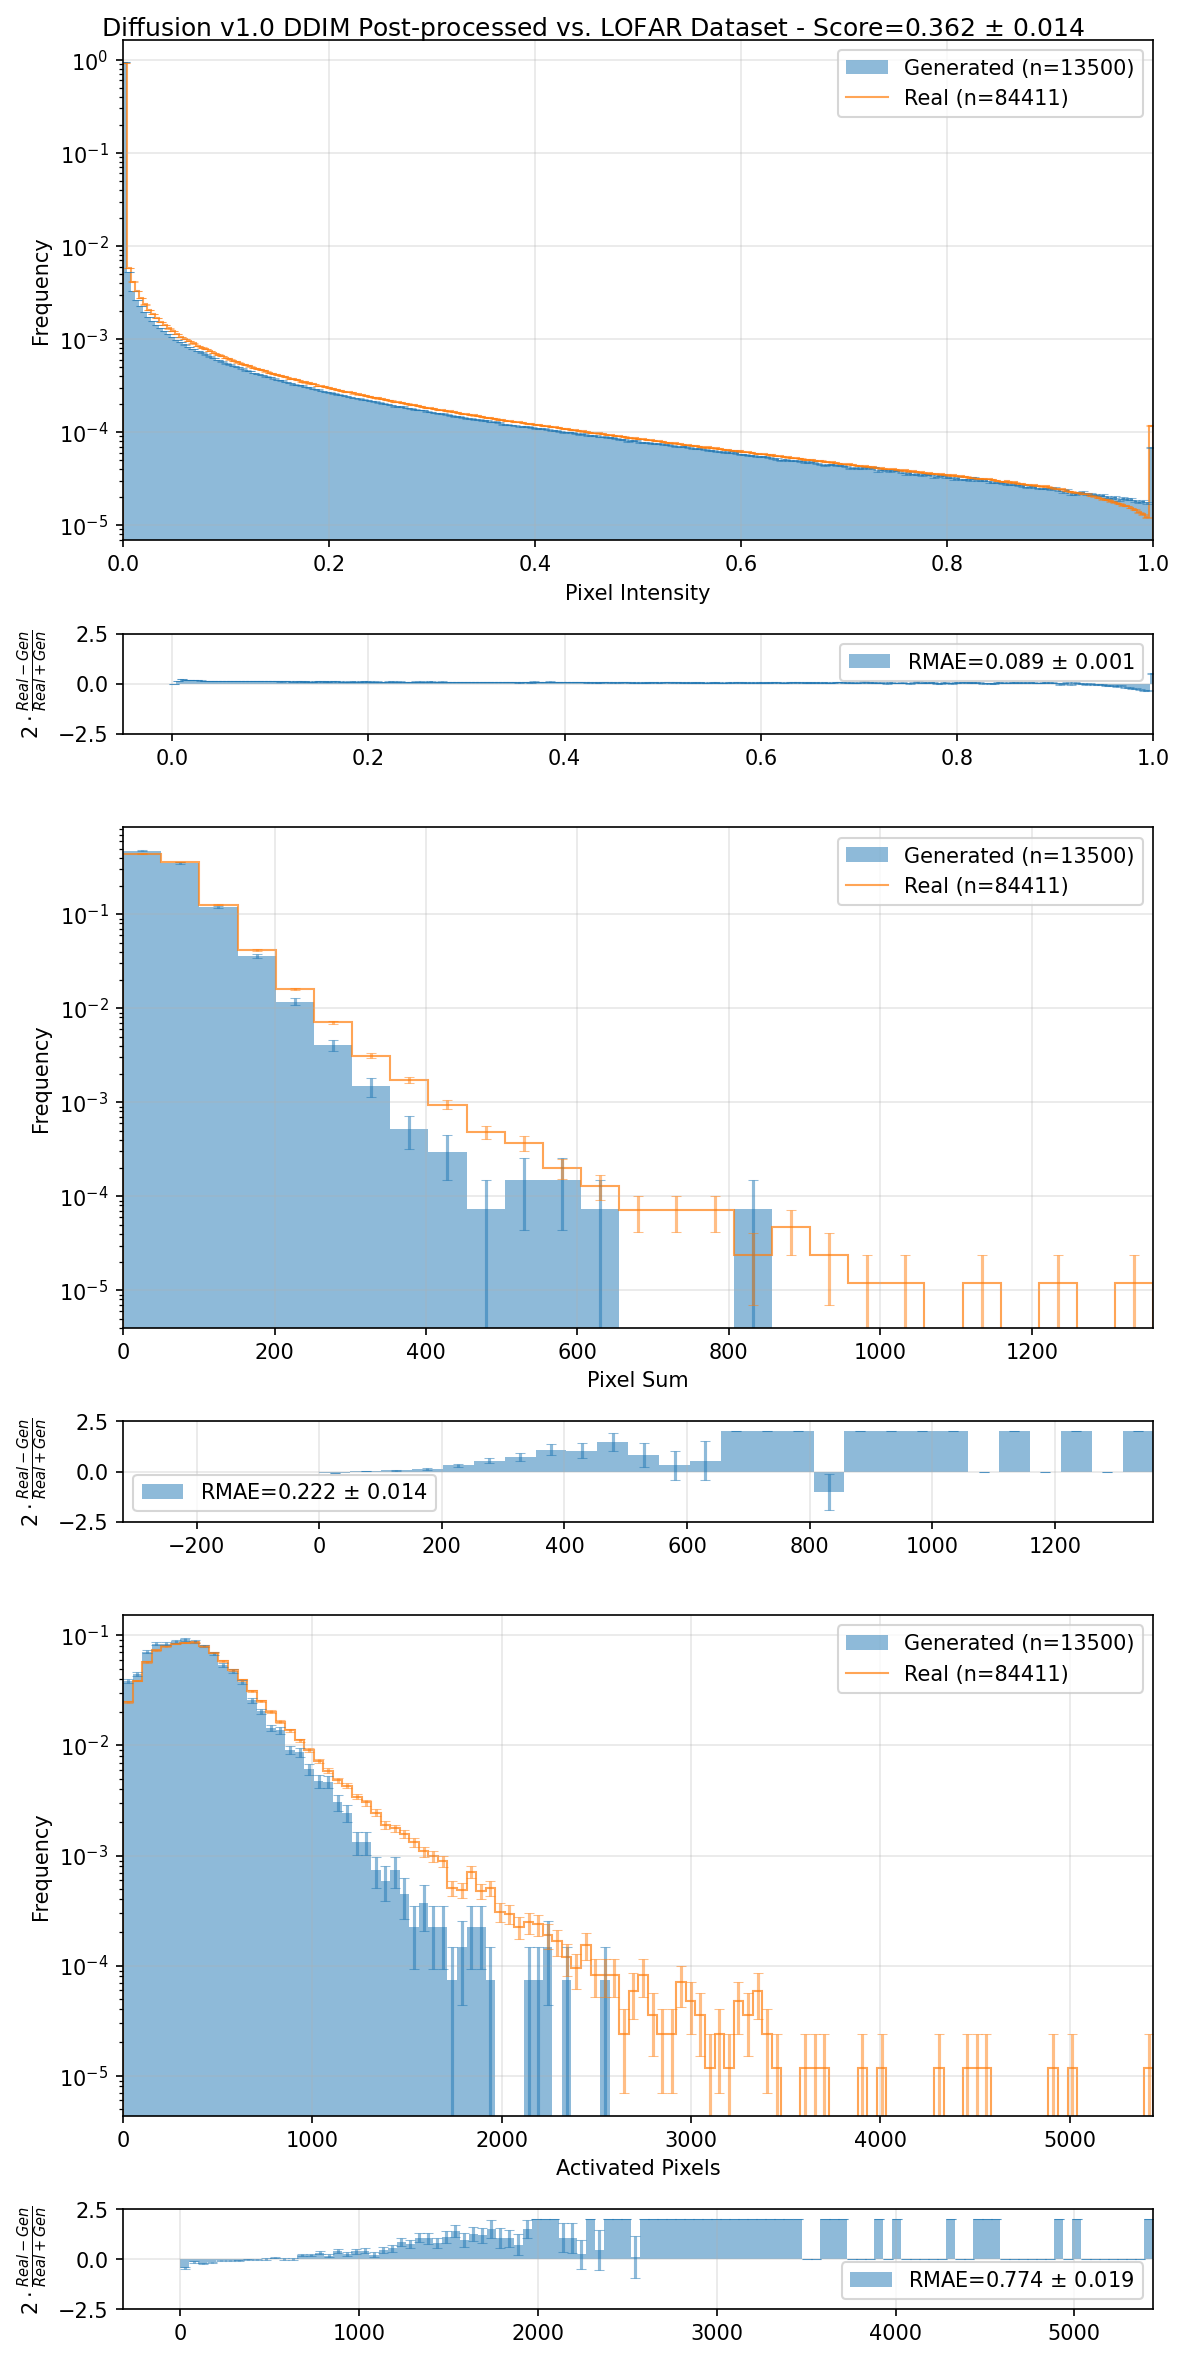

In [61]:
fig, axs = plt.subplots(6, 1, dpi=150, tight_layout=True, figsize=(8, 16),
                        height_ratios=[5,1,5,1,5,1])
get_centers = lambda edges: (edges[1:] + edges[:-1]) / 2

for ax, ax2, key in zip(axs[::2], axs[1::2], distr_lofar.keys()):
    c_gen, e_gen = distr_gen[key]
    norm = torch.sum(c_gen)
    err_gen = torch.sqrt(c_gen)
    ax.stairs(c_gen / norm, e_gen,
              alpha=0.5, fill=True, label=f"Generated (n={len(ds_gen)})",
              color="tab:blue")
    ax.errorbar(get_centers(e_gen), c_gen / norm,
                yerr=err_gen / norm,
                alpha=0.5, ls="none", color="tab:blue",
                capsize=2.5, capthick=0.5)
    
    
    c_lofar, e_lofar = distr_lofar[key]  # Counts, edges
    norm = torch.sum(c_lofar)
    err_lofar = torch.sqrt(c_lofar)
    ax.stairs(c_lofar / c_lofar.sum(), e_lofar,
               alpha=0.7, label=f"Real (n={len(ds_subset)})", color="tab:orange")
    ax.errorbar(get_centers(e_lofar), c_lofar / norm,
                yerr=err_lofar / norm,
                alpha=0.5, ls="none", color="tab:orange",
                capsize=2.5, capthick=0.5)
    
    xmax = torch.max(torch.cat([
        e_gen[1:][c_gen>0], e_lofar[1:][c_lofar>0]
    ])).item()
    ax.set_xlim(left=0, right=xmax)

    ax.set_ylabel("Frequency")
    ax.set_xlabel(key)
    ax.set_yscale("log")
    ax.grid(alpha=0.3)
    ax.legend()

    c, dc_sq, e = error[key]
    ax2.stairs(c, e, fill=True, alpha=0.5,
              label=f"RMAE={rmae[key][0].item():.3f} $\pm$ {torch.sqrt(rmae[key][1]).item():.3f}",
              color="tab:blue")
    ax2.errorbar(get_centers(e), c,
                yerr=torch.sqrt(dc_sq),
                alpha=0.5, ls="none", color="tab:blue",
                capsize=2.5, capthick=0.5)

    ax2.set_ylabel(r"$2 \cdot \frac{Real-Gen}{Real+Gen}$")
    ax2.grid(alpha=0.3)
    ax2.set_xlim(right=xmax)
    ax2.set_ylim(-2.5, 2.5)
    ax2.legend()

title = "Diffusion v1.0 DDIM vs. LOFAR Dataset"
fig.suptitle(f"{title} - Score={rmae['Sum'][0].item():.3f} $\pm$ {torch.sqrt(rmae['Sum'][1]).item():.3f}")
# fig.savefig(f"./analysis/dataset_comparisons/{title.replace('.', '')}.pdf")
fig.show()

In [70]:
rmae = RMAE(error)
repr(rmae)

"{'Pixel Intensity': tensor(11.3417), 'Pixel Sum': tensor(18.1501), 'Activated Pixels': tensor(10.4282), 'Sum': tensor(39.9200)}"

## Find closest images

In [98]:
from sklearn.decomposition import PCA
from scipy.ndimage import rotate
import itertools

In [100]:
def align_image(img):
    X = np.array(np.where(img > 0)).T
    # Perform a PCA and compute the angle of the first principal axes
    try:
        pca = PCA(n_components=2).fit(X)
    except ValueError:
        return torch.zeros(1, 80, 80), -1  # If every pixel is 0
    angle = np.arctan2(*pca.components_[0])
    # Rotate the image by the computed angle:
    rotated_img = rotate(img,angle/np.pi*180 - 90, reshape=False)
    return torch.tensor(rotated_img.reshape(1,80,80)), angle/np.pi*180 - 90

def deltas(b1, b2):
    len1, len2 = [b.shape[0] for b in [b1, b2]]
    pairs = list(itertools.product(range(len1), range(len2)))
    deltas = []

    for i, j in tqdm(pairs, desc="Comparing pair-wise..."):
        img1 = align_image(b1[i].squeeze())[0]
        img2 = align_image(b2[j].squeeze())[0]

        diff = (img1 - img2).abs().sum()
        deltas.append(torch.tensor([i, j, diff]))
    
    return torch.vstack(deltas)

def get_pairs(b1, b2, delta, n=10):
    ind = delta[:,-1].argsort(dim=0)
    sorted_pairs = delta[:,:-1][ind][:n]
    imgs = []

    for pair in sorted_pairs:
        i, j = pair
        img1 = b1[int(i)].squeeze()
        img2 = b2[int(j)].squeeze()
        imgs.append(torch.stack([img1, img2]))
    
    return torch.stack(imgs)

def plot_pair(pair, titles):
    fig = plt.figure()
    for i, (img, title) in enumerate(zip(pair, titles)):
        ax = fig.add_subplot(1, 2, i+1)
        ax.imshow(img, vmin=0, vmax=1)
        ax.set_title(title)
    return fig


torch.Size([500, 1, 80, 80]) torch.Size([500, 1, 80, 80])
torch.Size([4, 1, 80, 80]) torch.Size([11, 1, 80, 80])


Comparing pair-wise...: 100%|██████████| 44/44 [00:00<00:00, 480.24it/s]


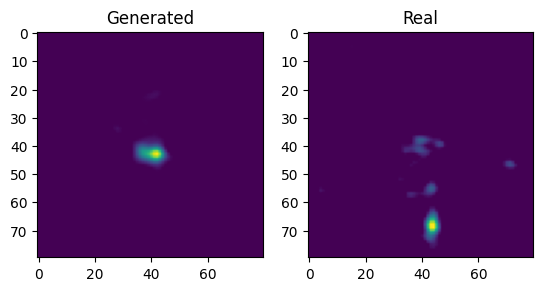

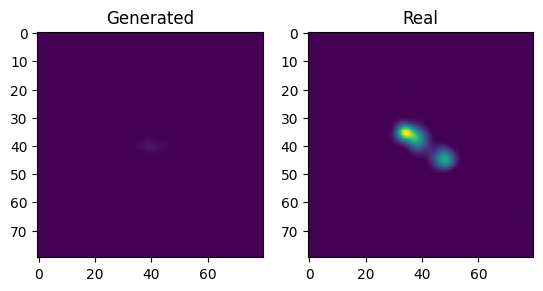

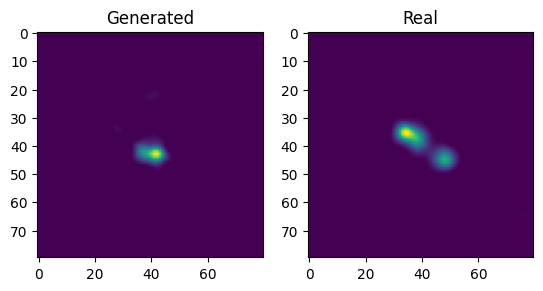

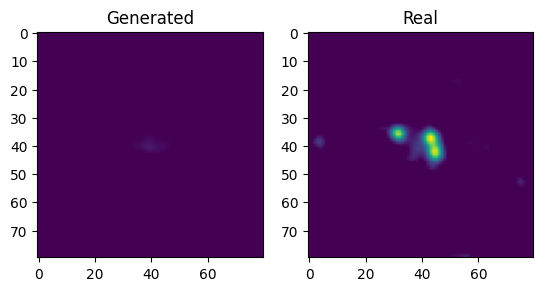

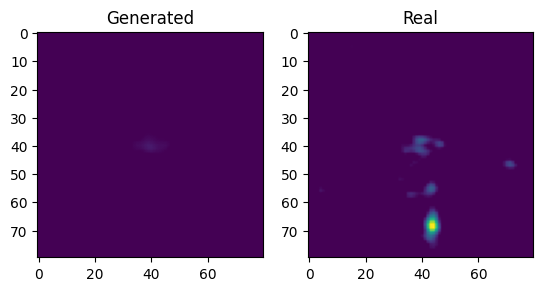

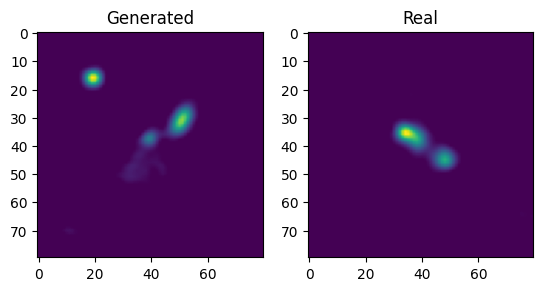

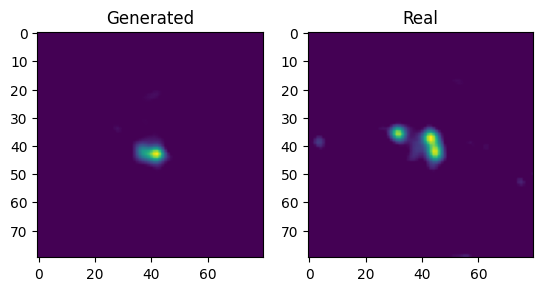

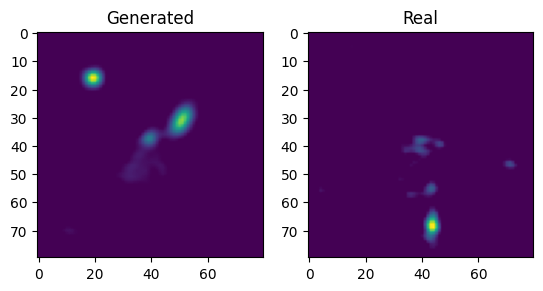

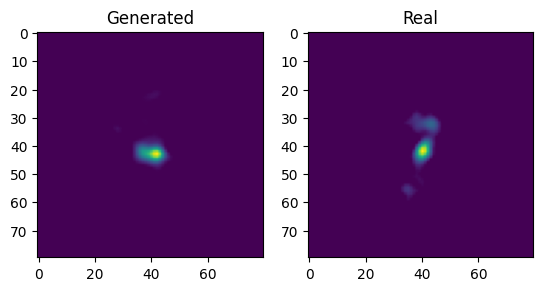

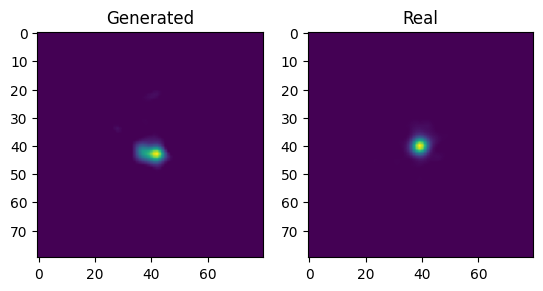

In [128]:
get_dl = lambda ds: DataLoader(ds, batch_size=500, shuffle=True)

dl_lofar = get_dl(ds_lofar)
dl_gen = get_dl(ds_gen)

b_gen = next(iter(dl_gen))
b_lofar = next(iter(dl_lofar))

print(b_gen.shape, b_lofar.shape)

get_active = lambda b: b[(b.sum(dim=(1, 2, 3)) > 250).nonzero().squeeze()]

active_gen, active_lofar = get_active(b_gen), get_active(b_lofar)

print(active_gen.shape, active_lofar.shape)

delta = deltas(active_gen, active_lofar)
pairs = get_pairs(b_gen, b_lofar, delta, n=100)

for pair in pairs[:10]:
    fig = plot_pair(pair, titles=["Generated", "Real"])
    fig.show()